In [1]:
import numpy as np
from tqdm import tqdm, trange
import os
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, LambdaLR
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset,ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.transforms as transforms
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import confusion_matrix

np.random.seed(0)
torch.manual_seed(0)
NUM_WORKERS = os.cpu_count()

In [2]:
import numpy as np
import torch
import torchvision
from torch.nn import CrossEntropyLoss
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def patchify(images, n_patches):
    # Your patchify implementation goes here
    n, c, h, w = images.shape
    patch_size_h = h // n_patches
    patch_size_w = w // n_patches
    patches = torch.empty((n, n_patches ** 2, c * patch_size_h * patch_size_w), device=images.device)

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size_h: (i + 1) * patch_size_h, j * patch_size_w: (j + 1) * patch_size_w]
                patches[idx, i * n_patches + j] = patch.flatten()

    return patches

In [4]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [5]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=8):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [6]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [7]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches, n_blocks, hidden_d, n_heads, num_classes):
        super(MyViT, self).__init__()
        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by the number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by the number of patches"
        self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, hidden_d)
        self.class_token = nn.Parameter(torch.rand(1, hidden_d))
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, num_classes),
            nn.Softmax(dim=-1)
        )
        

    def forward(self, images):
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        tokens = self.linear_mapper(patches)
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        for block in self.blocks:
            out = block(out)
        out = out[:, 0]
        return self.mlp(out)
                # Output shape: [batch_size, num_classes]

        # Get the class with the highe

In [8]:
def warmup_lambda(current_step,warmup_steps):
    if current_step < warmup_steps:
        return current_step / warmup_steps
    else:
        return 1.0

In [9]:
def generate_text_from_class(class_index, predicted_class_names):
    # Define prompt
    class_name = predicted_class_names[class_index]
    prompt = f"Generate text for class {class_name}."

    # Define model and tokenizer
    model_name = 't5-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
                                                            
    # Tokenize prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # Generate text
    output = model.generate(input_ids, max_length=100, num_beams=5)

    # Decode text
    generated_text = tokenizer.decode(output[0])

    # Print generated text
    print(generated_text)

In [10]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [11]:
    device = torch.device("cpu")
    #print("Using device:", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    # Loading data
    train_set = '/home/medikondamanisumanth/project/Project/Damage Type.v1-damage-type-v1.tensorflow/train_2'
    test_set = '/home/medikondamanisumanth/project/Project/Damage Type.v1-damage-type-v1.tensorflow/test_1'
    valid_set = '/home/medikondamanisumanth/project/Project/Damage Type.v1-damage-type-v1.tensorflow/valid_1'
    
    
    # Define transformations
    transform = transforms.Compose([
        transforms.RandomResizedCrop((720, 720), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])



    # Create datasets
    train_dataset_original = ImageFolder(train_set, transform=transform)
    #train_dataset_augmented = ImageFolder(train_set, transform=transform_add)
    #combined_train_dataset = ConcatDataset([train_dataset_original, train_dataset_augmented])
    test_dataset_original = ImageFolder(test_set, transform=transform)
    #test_dataset_augmented = ImageFolder(test_set, transform=transform_add)
    #combined_test_dataset = ConcatDataset([test_dataset_original, test_dataset_augmented])
    valid_dataset = ImageFolder(valid_set, transform=transform)

    # Define data loaders
    train_loader = DataLoader(train_dataset_original, shuffle=True, batch_size=64, num_workers=4)
    test_loader = DataLoader(test_dataset_original, shuffle=False, batch_size=64, num_workers=4)
    valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=64, num_workers=4)

In [ ]:
    model = MyViT(chw=(3, 720, 720), n_patches=8, n_blocks=4, hidden_d=1024, n_heads=8, num_classes=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-09, weight_decay=0.001, amsgrad=False)
    criterion = nn.CrossEntropyLoss()

    # More Training Epochs
    N_EPOCHS = 5

    # Define learning rate scheduler
    warmup_steps = 500 # Adjust this value as needed
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_lambda(epoch, warmup_steps))
    log_interval = 10
    for epoch in range(N_EPOCHS):
        model.train()
        correct = 0
        total = 0
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
            total += target.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_acc = 100. * correct / total
        print(f'Train Epoch: {epoch+1}/{N_EPOCHS}, Loss: {train_loss:.6f}, Accuracy: {train_acc:.2f}%')
        #scheduler.step()
    # Save the trained model
    torch.save(model.state_dict(), 'vit_model.pth')
    model.load_state_dict(torch.load('vit_model.pth'))

In [ ]:
            
            model.eval()
            train_predicted_probabilities = []
            train_targets = []
            with torch.no_grad():
                correct, total = 0, 0
                train_loss = 0.0
                for batch_idx, (data, target) in enumerate(train_loader):
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
            
                    train_loss += loss.detach().cpu().item()/len(train_loader)
                    correct += torch.sum(torch.argmax(output, dim=1) == target).detach().cpu().item()
                    total += len(data)
                    predicted_probabilities = torch.nn.functional.softmax(output, dim=1)
            
                    for i in range(len(target)):
                        train_predicted_probabilities.append(predicted_probabilities[i].detach().cpu().numpy())
                        train_targets.append(target[i].item())
            train_predicted_probabilities = np.array(train_predicted_probabilities)
            
            # Compute the predicted classes based on the probability values
            train_predictions = np.argmax(train_predicted_probabilities, axis=1)
            
            # Compute the confusion matrix
            confusion_mtx = confusion_matrix(train_targets, train_predictions)
            predicted_class_names = ['Combined damage', 'Flexural', 'Shear', 'Undamage']
            # Plot confusion matrix as heatmap
            plt.figure(figsize=(12, 12))
            sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=predicted_class_names,
                         yticklabels=predicted_class_names)
            plt.xlabel('Predicted class')
            plt.ylabel('True class')
            plt.show()

In [13]:
model.eval()
train_predicted_probabilities = []
train_targets = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted_probabilities = torch.nn.functional.softmax(output, dim=1)
        
        # Append the predicted probabilities and target labels
        train_predicted_probabilities.append(predicted_probabilities.cpu().numpy())
        train_targets.append(target.cpu().numpy())

# Concatenate the predicted probabilities and target labels
train_predicted_probabilities = np.concatenate(train_predicted_probabilities)
train_targets = np.concatenate(train_targets)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(train_targets.argmax(axis=1), train_predicted_probabilities.argmax(axis=1))

# Plot confusion matrix as heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=predicted_class_names,
             yticklabels=predicted_class_names)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

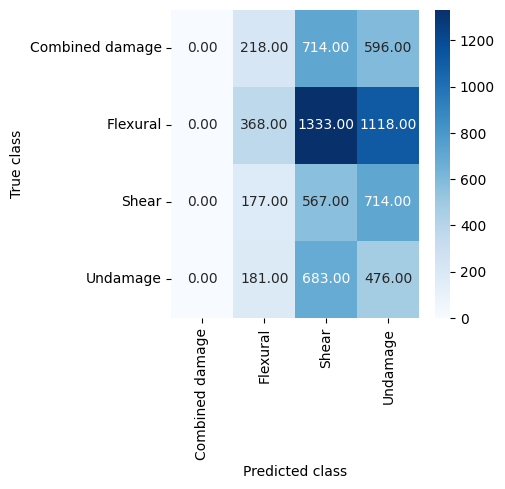

In [25]:
model.eval()
train_predicted_probabilities = []
train_targets = []
with torch.no_grad():
    correct, total = 0, 0
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        train_loss += loss.detach().cpu().item()/len(train_loader)
        predicted_probabilities = torch.nn.functional.softmax(output, dim=1)
        for i in range(len(target)):
            train_predicted_probabilities.append(predicted_probabilities[i].detach().cpu().numpy())
            train_targets.append(target[i].item())

train_predicted_probabilities = np.array(train_predicted_probabilities)

# Compute the confusion matrix based on the probability values
confusion_mtx = confusion_matrix(train_targets, np.argmax(train_predicted_probabilities, axis=1))
predicted_class_names = ['Combined damage', 'Flexural', 'Shear', 'Undamage']

# Plot confusion matrix as heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=predicted_class_names,
             yticklabels=predicted_class_names)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

Test accuracy: 41.18%
Test loss: 1.31


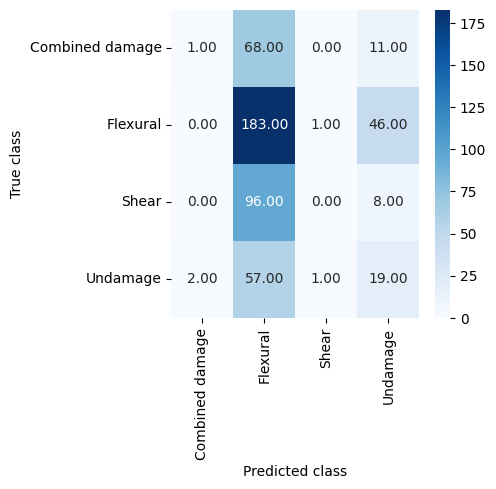

In [14]:

            model.eval()
            test_predicted_probabilities = []
            test_targets = []
            with torch.no_grad():
                correct, total = 0, 0
                test_loss = 0.0
                for batch_idx, (data, target) in enumerate(test_loader):
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
            
                    test_loss += loss.detach().cpu().item()/len(test_loader)
                    correct += torch.sum(torch.argmax(output, dim=1) == target).detach().cpu().item()
                    total += len(data)
                    predicted_probabilities = torch.nn.functional.softmax(output, dim=1)
            
                    for i in range(len(target)):
                        test_predicted_probabilities.append(predicted_probabilities[i].detach().cpu().numpy())
                        test_targets.append(target[i].item())
            
                test_accuracy = 100. * correct / total
                print(f"Test accuracy: {test_accuracy:.2f}%")
                print(f"Test loss: {test_loss:.2f}")
            
            # Convert list to numpy array
            test_predicted_probabilities = np.array(test_predicted_probabilities)
            
            # Compute the predicted classes based on the probability values
            test_predictions = np.argmax(test_predicted_probabilities, axis=1)
            
            # Compute the confusion matrix
            confusion_mtx = confusion_matrix(test_targets, test_predictions)
            predicted_class_names = ['Combined damage', 'Flexural', 'Shear', 'Undamage']
            # Plot confusion matrix as heatmap
            plt.figure(figsize=(4, 4))
            sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=predicted_class_names,
                         yticklabels=predicted_class_names)
            plt.xlabel('Predicted class')
            plt.ylabel('True class')
            plt.show()
            
            # Generate text based on the predicted class
            predicted_class_names = ['Combined damage', 'Flexural', 'Shear', 'Undamage']
            #for i in range(len(test_predictions)):
                #class_index = test_predictions[i]
                #generate_text_from_class(class_index, predicted_class_names)